Title: Building a Movie Recommendation System

Introduction:
In this project, we aim to build a movie recommendation system using the MovieLens dataset from the GroupLens research lab at the University of Minnesota. Our goal is to create a model that provides top 5 movie recommendations to a user based on their ratings of other movies. Recommendation systems are widely used in the entertainment industry to enhance user experience and engagement. We will delve into the specific details of how the user will provide their ratings and formulate a more concrete business problem within the context of recommending movies.

Dataset:
We will use the "small" MovieLens dataset, which contains 100,000 user ratings. This dataset includes information about movies, user ratings, and user demographics, making it suitable for building a recommendation system.

Business Problem:
Our business problem revolves around improving user engagement and satisfaction on a movie streaming platform. The primary objective is to increase user retention and movie consumption by providing personalized movie recommendations.

User Interaction:
To gather user ratings and preferences, we will implement an interactive rating system on the platform. When a user logs in or creates an account, they will be prompted to rate a set of movies. The initial set of movies can be randomly selected from a pool of popular and diverse films in the dataset to get an initial understanding of the user's preferences.

Continuous Feedback:
The system will continuously gather feedback from the user. After each movie watched, the user will be asked to rate the movie on a scale of 1 to 5 stars or provide a thumbs-up/thumbs-down rating. These ratings, along with the user's viewing history, will be used to refine the recommendations.

Data Collection and Preprocessing:
1. User Ratings: We will collect and store user ratings in our database, associating each rating with a user ID and a movie ID.
2. User Demographics: We will also collect information about user demographics, such as age, gender, and location, to create more personalized recommendations.
3. Movie Data: We will use movie attributes such as genre, release year, and director to enrich our recommendation algorithm.
4. Collaborative Filtering: We will employ collaborative filtering techniques to identify users with similar preferences and recommend movies that those users enjoyed.

Recommendation Algorithm:
We will implement a hybrid recommendation system that combines collaborative filtering and content-based filtering. Collaborative filtering will help us identify users with similar tastes, while content-based filtering will recommend movies based on their attributes and characteristics.

Evaluation:
We will use metrics such as Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and Precision-Recall to evaluate the performance of our recommendation system. These metrics will help us assess how well our system predicts user preferences and provides relevant recommendations.

User Experience:
To enhance the user experience, we will implement features such as:

1. Real-time recommendations: Movies recommended as soon as a user logs in or finishes watching a movie.
2. Personalized homepage: A curated list of movie recommendations based on the user's preferences.
3. Recommendations for similar users: Highlighting movies liked by users with similar tastes.
4. Diversity in recommendations: Ensuring that the recommendations include a variety of genres and styles.
5. Explanation of recommendations: Providing reasons for why a movie is recommended (e.g., "Recommended because you liked [Movie Name]").

Conclusion:
Building an effective movie recommendation system can significantly improve user engagement and satisfaction on a streaming platform. By continuously collecting user ratings and utilizing collaborative and content-based filtering, we aim to provide top 5 movie recommendations tailored to each user's unique preferences, thereby enhancing their overall experience.

In [177]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [178]:
# Read the 'links.csv' file into a DataFrame
df_links = pd.read_csv('Dataset\links.csv')
df_links.head()


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [179]:
# Read the 'movies.csv' file into a DataFrame
df_movies = pd.read_csv('Dataset\movies.csv')
df_movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [180]:
# Read the 'ratings.csv' file into a DataFrame
df_ratings = pd.read_csv(r"Dataset\ratings.csv")
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [181]:
# Read the 'tags.csv' file into a DataFrame
df_tags = pd.read_csv(r"Dataset\tags.csv")
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [182]:
# Merge the DataFrames one by one based on the common key
merged_df = pd.merge(df_links, df_movies, on='movieId', how='inner')
merged_df = pd.merge(merged_df, df_ratings, on='movieId', how='inner')
merged_df = pd.merge(merged_df, df_tags, on=['movieId', 'userId',], how='inner')


# Save the merged data to a new CSV file
merged_df.to_csv('merged_data.csv', index=False)


In [183]:
merged_df.head()

,movieId,imdbId,tmdbId,title,genres,userId,rating,timestamp_x,tag,timestamp_y
0,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,4.0,1122227329,pixar,1139045764
1,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474,4.0,978575760,pixar,1137206825
2,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567,3.5,1525286001,fun,1525286013
3,2,113497,8844.0,Jumanji (1995),Adventure|Children|Fantasy,62,4.0,1528843890,fantasy,1528843929
4,2,113497,8844.0,Jumanji (1995),Adventure|Children|Fantasy,62,4.0,1528843890,magic board game,1528843932


In [185]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3476 entries, 0 to 3475
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      3476 non-null   int64  
 1   imdbId       3476 non-null   int64  
 2   tmdbId       3476 non-null   float64
 3   title        3476 non-null   object 
 4   genres       3476 non-null   object 
 5   userId       3476 non-null   int64  
 6   rating       3476 non-null   float64
 7   timestamp_x  3476 non-null   int64  
 8   tag          3476 non-null   object 
 9   timestamp_y  3476 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 298.7+ KB


In [186]:
#checking for missing values
def missing_values(merged_df):
    # checks sum of missing values in the data
    missing = merged_df.isnull().sum()
    # Create a percentage of missing values in data.
    percentage = (merged_df.isnull().sum())/len(merged_df)
    # Store in a dataframe
    miss = pd.DataFrame({"missing values":missing, "Percentage of missing values": percentage})
    

    return miss 

Missing_Values = missing_values(merged_df)
print (Missing_Values)

             missing values  Percentage of missing values
movieId                   0                           0.0
imdbId                    0                           0.0
tmdbId                    0                           0.0
title                     0                           0.0
genres                    0                           0.0
userId                    0                           0.0
rating                    0                           0.0
timestamp_x               0                           0.0
tag                       0                           0.0
timestamp_y               0                           0.0


In [187]:
# checking for high rated movies
high_ratings=merged_df.groupby(['title'])[['rating']].sum()
high_rated=high_ratings.nlargest(20,'rating')
high_rated.head()

,rating
title,
Pulp Fiction (1994),902.0
Fight Club (1999),267.0
2001: A Space Odyssey (1968),203.0
Léon: The Professional (a.k.a. The Professional) (Léon) (1994),172.5
"Big Lebowski, The (1998)",158.5


<BarContainer object of 20 artists>

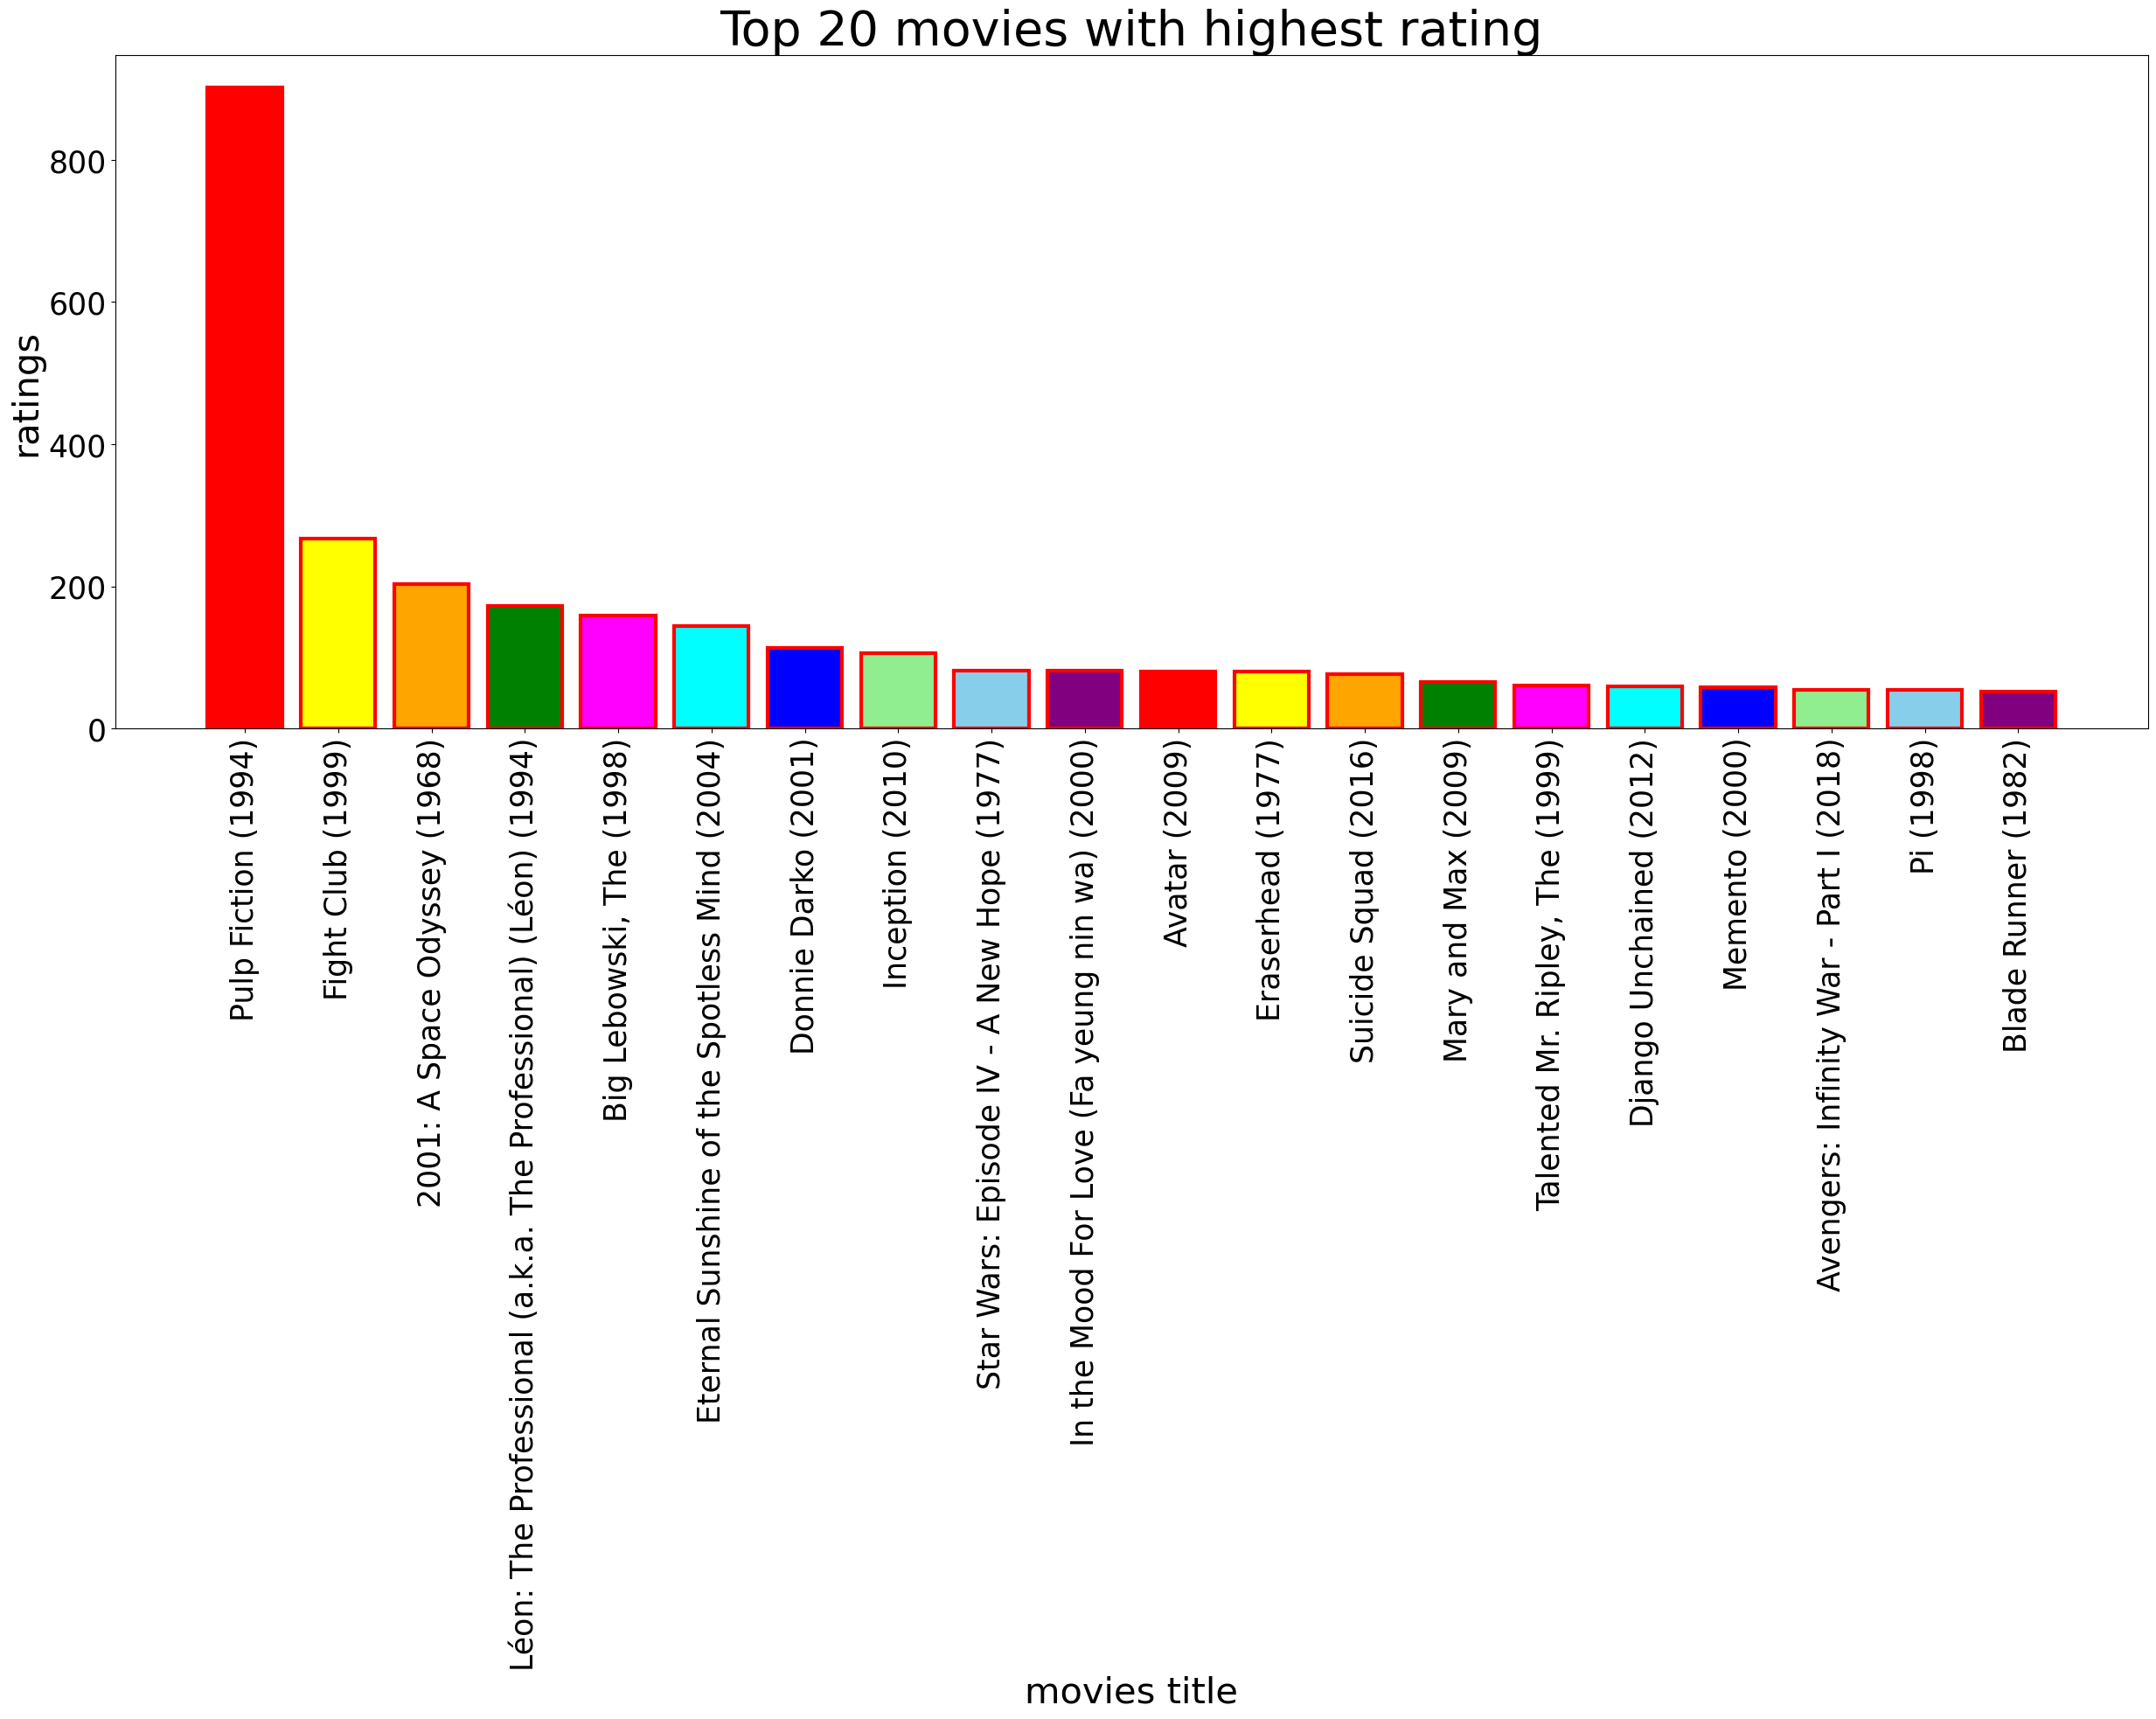

In [188]:
# graph of top 20 highly rated movies 
plt.figure(figsize=(30,10))
plt.title('Top 20 movies with highest rating',fontsize=40)
colors=['red','yellow','orange','green','magenta','cyan','blue','lightgreen','skyblue','purple']
plt.ylabel('ratings',fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.xlabel('movies title',fontsize=30)
plt.yticks(fontsize=25)
plt.bar(high_rated.index,high_rated['rating'],linewidth=3,edgecolor='red',color=colors)

In [189]:

# Create a TF-IDF vectorizer for genres
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['genres'])

In [190]:

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [191]:
def content_based_recommendations(movie_title, cosine_sim=cosine_sim, top_n=10):
    # Get the index of the movie that matches the title
    idx = merged_df[merged_df['title'] == movie_title].index[0]
    
    # Get the pairwsie similarity scores for all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top N most similar movies
    sim_scores = sim_scores[1:top_n + 1]  # Exclude the input movie itself
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top N recommended movie titles
    recommended_movies = merged_df['title'].iloc[movie_indices].tolist()
    
    return recommended_movies


In [192]:
movie_title = "Jumanji (1995)"
recommendations = content_based_recommendations(movie_title)
print(recommendations)


['Jumanji (1995)', 'Jumanji (1995)', 'Jumanji (1995)', "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)"]


In [193]:
# Create the user-item matrix
user_item_matrix = df_ratings.pivot_table(columns='userId',index='movieId',values='rating')

user_item_matrix



userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
user_item_matrix.fillna(0,inplace=True)

user_item_matrix


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:

movie_sparse = csr_matrix(user_item_matrix)

# Create a Nearest Neighbors model
model = NearestNeighbors(n_neighbors=7, algorithm='brute', metric='cosine')
model.fit(movie_sparse)

def reco(movie_name, num_recommendations=5):
    # Find the movie_id for the given movie name
    movie_id = merged_df[merged_df['title'] == movie_name]['movieId'].values
    if len(movie_id) == 0:
        return "Movie not found in the dataset"

    # Get the recommendations for the given movie
    distances, suggestions = model.kneighbors(user_item_matrix.iloc[movie_id[0], :].values.reshape(1, -1))

    # Extract the movie indices from the suggestions
    recommended_movie_indices = suggestions[0]

    # Filter out the input movie from the recommendations
    recommended_movie_indices = [idx for idx in recommended_movie_indices if idx != movie_id[0]]

    # Get the actual movie titles from the movie indices
    recommended_movies = merged_df.iloc[recommended_movie_indices]['title'].values[:num_recommendations]

    return recommended_movies

# Example usage:
recommended_movies = reco("Toy Story (1995")
print(recommended_movies)


Movie not found in the dataset
